---
title: Evaluating CHIRPS with Local Rainfall Data
description: This notebook evaluates the performance of CHIRPS rainfall data against local weather station observations in the Citarum Basin, Indonesia.
author:
  - name:
      given: Taruma Sakti
      family: Megariansyah
      # literal: Taruma Sakti Megariansyah
    orcid: 0000-0002-1551-7673
    email: hi@taruma.info
    url: https://dev.taruma.info
abstract: > 
  {{< lipsum 1 >}}
keywords:
  - CHIRPS
  - Citarum Watershed
  - Rainfall
  - Precipitation
  - Hydrology
  - Data Comparison
  - Data Analysis
  - Indonesia
license: "CC BY-NC"
copyright: 
  holder: Taruma Sakti Megariansyah
  year: 2024
date: 2024-12-14
date-modified: last-modified
date-format: full
format:
    html:
        code-fold: true
        number-sections: true
        # toc-title: Daftar Isi
        other-links:
        - text: My Github
          icon: github
          href: https://github.com/taruma
        - text: My Other Projects
          icon: journals
          href: https://dev.taruma.info/projects
        - text: Sponsor Me
          icon: heart
          href: https://github.com/sponsors/taruma
        - text: Buy Me a Drink
          icon: cup-straw
          href: https://trakteer.id/taruma/tip
        code-links:
        - text: Repository
          icon: github
          href: https://github.com/taruma/rf-comp-id
        - text: Source Code
          icon: code
          href: https://github.com/taruma/rf-comp-id/blob/main/notebook_en.ipynb
        theme: journal
        toc: true
        toc-location: left
        toc-expand: 2
        toc-depth: 4
        embed-resources: true
        css: assets/quarto_styles.css
include-in-header: # from: https://github.com/quarto-dev/quarto-cli/discussions/4618
  - text: |
      <link rel = "shortcut icon" href = "favicon-ti.png" />
execute:
  cache: true
  enabled: false
  echo: false
citation: 
  url: https://dev.taruma.info/rf-comp-id/notebook_en.html
lightbox: auto
lang: en
title-block-banner: true
# title-block-banner: banner.png
# title-block-banner-color: black
---


Imagine two weather reporters, one in a satellite 🛰️ high above the Earth and one on the ground at a local weather station 📡. They're both reporting on the same thing: **rainfall** 🌧️. The satellite reporter represents global, gridded rainfall datasets like _CHIRPS_ (Climate Hazards Group InfraRed Precipitation with Station data), which provide a broad, top-down view of rainfall patterns across vast regions. The ground reporter represents the network of local weather stations, collecting precise rainfall measurements at specific points on the Earth's surface. Are these two reporters telling the same story about the rain? 🤔 How consistent are their reports? That's what we're going to explore in this notebook!

Essentially, we'll be playing the role of **fact-checkers**, scrutinizing the rainfall data from both our "reporters." We'll use a variety of tools and techniques to _analyze_ the data, create _visualizations_, and assess the _reliability_ of each source. This will involve looking for trends, calculating statistics, and even comparing how they describe specific events, like heavy downpours. Understanding the **strengths** and **weaknesses** of both satellite-derived and ground-based rainfall data is crucial. It can help us improve hydrological models, inform water management strategies, and enhance our ability to predict and respond to extreme weather events, no matter where we are in the world. By the end of this notebook, we'll have a clearer picture of how to interpret and utilize these different sources of rainfall information for a more comprehensive understanding of our planet's precipitation patterns. Let's get started!

::: {.callout-important}
## About this notebook

This notebook provides an educational demonstration on analyzing and comparing rainfall data from different sources, with a focus on the process rather than being a definitive research paper. It's open-source, so you're welcome to use and adapt it. If you find any errors or have suggestions, please help improve this resource by creating [an issue on the GitHub](https://github.com/taruma/rf-comp-id). Your input is greatly valued!
:::

In [2]:
#| echo: true

import geopandas as gpd
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import json
import myfunc
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from IPython.display import display # noqa
import pytemplate # noqa

## Introduction

This chapter provides the foundational context for this notebook, outlining the critical role of accurate rainfall data in effective water resource management. It introduces the two primary data sources, CHIRPS and BBWS Citarum, and describes the Citarum River Basin as the study area. 

### Project Background and Objectives

Rainfall is a crucial element in managing water resources, especially in a region like the Citarum River Basin. Understanding how much rain falls, where it falls, and when it falls is essential for preventing floods, managing droughts, and ensuring a reliable water supply for communities and agriculture. This notebook focuses on comparing two different sources of rainfall data: one from a global satellite-based system called CHIRPS and another from local rain gauges operated by BBWS Citarum, which we consider as the ground truth. By examining how well these two datasets agree, we can gain valuable insights into the accuracy of the satellite data and its potential for improving water management practices in the region.

The main goal of this notebook is to see how well the CHIRPS rainfall data matches up with the measurements taken from rain gauges on the ground (BBWS Citarum). We want to find out if the satellite data is consistent with the ground truth, where they might differ, and what those differences might mean for understanding rainfall patterns in the Citarum River Basin. Ultimately, this comparison will help us determine if CHIRPS data can be a reliable tool for supporting water resource management decisions, especially in areas where ground-based measurements are limited.

### Data Sources

This section will briefly introduce the two datasets we're using in this project: CHIRPS and BBWS Citarum. 

- **CHIRPS (Climate Hazards Group InfraRed Precipitation with Station data)**: Climate Hazards Group InfraRed Precipitation with Station data (CHIRPS) is a 35+ year quasi-global rainfall data set. Spanning 50°S-50°N (and all longitudes) and ranging from 1981 to near-present, CHIRPS incorporates their in-house climatology, CHPclim, 0.05° resolution satellite imagery, and in-situ station data to create gridded rainfall time series for trend analysis and seasonal drought monitoring ^[https://www.chc.ucsb.edu/data/chirps]. It's especially helpful in areas where there aren't many weather stations on the ground. 

- **BBWS Citarum (Balai Besar Wilayah Sungai Citarum)**: This organization is responsible for managing water resources within the Citarum River Basin. They collect rainfall data using a network of rain gauges located throughout the basin. These rain gauges provide direct measurements of rainfall at specific points, which we consider our "ground truth" data. However, it is only cover specific area within Citarum River Basin. We will select rainfall data from automatic rain gauges operated by BBWS Citarum in this notebook.

We will go into more detail about how we access and process the data from each source in the next chapter ([Chapter 2: Data Acquisition and Preprocessing](#data-acquisition-and-preprocessing)).

### Study Area

In this notebook, we'll be exploring rainfall data from a specific area in Indonesia called the Upper Citarum River Watershed (or "DAS Citarum Hulu" in Indonesian). Think of it as our area of interest for this project! This watershed is important for managing water in West Java. It's a fairly large area, covering about 1,738 square kilometers – that's a bit bigger than the size of London or New York City.

In [3]:
# | label: fig-interactive-upper-citarum-watershed
# | fig-cap: Upper Citarum Watershed

# Read the shapefile
gdf = gpd.read_file("data/gis/watershed_citarum_hulu.shp")
gdf = gdf.to_crs("EPSG:4326")
longs, lats = gdf.geometry[0].geoms[0].exterior.xy

fig = go.Figure()

citarum_watershed = go.Choroplethmap(
    geojson=gdf.__geo_interface__,
    locations=gdf.index,
    z=gdf.index,
    marker=dict(opacity=0.5, line_width=3),
    hoverinfo="skip",
    showscale=False
)

fig.add_trace(citarum_watershed)
fig.update_geos(fitbounds="locations", visible=False)
fig.update_layout(
    margin={"l": 0, "t": 0, "b": 0, "r": 0},
    map={
        "style": "open-street-map",
        "center": {"lon": np.mean(longs), "lat": np.mean(lats)},
        "zoom": 9,
    },
    # height=450,
    # showlegend=False,
)

fig.show()

Geographically, the Upper Citarum River Watershed sits between 6°45' and 7°15' South latitude and 107°21' and 107°57' East longitude. Parts of several cities and regions fall within this watershed, including Bandung City, Cimahi City, Bandung Regency, and Sumedang Regency. You can see the location of the watershed on @fig-interactive-upper-citarum-watershed.

---

## Data Acquisition and Preprocessing

This chapter details the process of acquiring and preparing the rainfall data from our two sources: the satellite-based CHIRPS dataset and the ground-based measurements from BBWS Citarum rain gauges. We will outline the steps taken to download, clean, and align these datasets, ensuring they are compatible for a robust comparison within the Upper Citarum River Watershed for a defined time period. This meticulous preparation is crucial to ensure the accuracy and reliability of our subsequent analysis.


### CHIRPS Data

Building upon our introduction, we now delve into the specifics of our data sources, beginning with the Climate Hazards Group InfraRed Precipitation with Station data (CHIRPS). In this section, we'll detail how we obtained the CHIRPS data for our study area, the Upper Citarum River Watershed, from the ClimateSERV platform, a tool designed for visualizing and downloading historical and forecasted climate data. While CHIRPS data is available from various sources, we opted for ClimateSERV for its user-friendly interface, which produced the data in netCDF4 format.


#### Using ClimateSERV to Obtain CHIRPS Data

For this analysis, we'll be using the [ClimateSERV platform](https://climateserv.servirglobal.net/map) to obtain CHIRPS rainfall data specifically for the Upper Citarum River Watershed. ClimateSERV offers a user-friendly interface for downloading pre-processed climate data. Follow these steps to get the data:

![CHIRPS Data Download from ClimateSERV](assets/img/fig-climateserv-chirps.png){#fig-climateserv-chirps width=450}

1. **Navigate to ClimateSERV:** Open your web browser and go to [https://climateserv.servirglobal.net/map](https://climateserv.servirglobal.net/map).

2. **Set Area of Interest (AOI):**

    - On the left panel, you'll see "Statistical Query" and "Set Area of Interest."
    - Click on the "**Upload**" tab under "Set Area of Interest."
    - You can either drag and drop your shapefile (in .zip, .json, or .geojson format) representing the Upper Citarum River Watershed boundary or click to select the file from your computer. The map on the right will automatically zoom into the uploaded shapefile as shown on @fig-climateserv-chirps. If you don't have a shapefile, you can use the "Draw" option to manually draw a rectangle around the area, but this method is less precise. For this case we use boundary of upper citarum basin which highlited with blue line.

3. **Select Data Parameters:**

    - Under "Select Data," choose "**Download Raw Data**" for "Type of Request."
    - Select "**Observation**" for "Dataset Type."
    - Choose "**UCSB CHIRPS Rainfall**" as the "Data Source."
    - Select "**NetCDF**" as the "Download Format."

4. **Specify Date Range:**

    - Set the "Date Range" according to your analysis period. For this example, let's use **2007-01-01** as the start date and **2019-12-31** as the end date.

5. **Submit Query:**

    - Click the "**Submit Query**" button. ClimateSERV will process your request. The downloaded file will be contain NetCDF file (.nc), containing CHIRPS rainfall data clipped to the Upper Citarum River Watershed for the specified period.

By following these steps, we efficiently obtain CHIRPS data that is both spatially and temporally aligned with our study area and period, ready for further processing and analysis.


#### Opening and Inspecting CHIRPS Data

Having successfully downloaded our CHIRPS rainfall data from ClimateSERV, clipped precisely to the Upper Citarum River Watershed and covering the years 2007 to 2019, we now turn to the crucial next step: opening and inspecting this NetCDF file to understand its structure and contents. In this section, we'll use specialized libraries to load the data, explore its dimensions, variables, and attributes, and gain a firm grasp of what this satellite-derived rainfall dataset truly represents before we move forward with any further processing or analysis. Essentially, we're ready to unpack our data and see what's inside, ensuring we have a solid foundation for comparing it with our ground-based measurements later on.

##### Loading the NetCDF File

With our CHIRPS data downloaded and ready, the first step is to load it into our computing environment so we can begin exploring its contents. For this task, we'll be leveraging the powerful `xarray` library in Python, which is specifically designed for working with labeled, multi-dimensional datasets like the NetCDF files commonly used in climate science. Let's store the path to our downloaded NetCDF file, which is conveniently named `chirps_2007_2019_citarum_watershed.nc`, in a variable called `CHIRPS_PATH` for easy reference.

In [4]:
# Define the path to the CHIRPS NetCDF file
CHIRPS_PATH = "data/chirps_2007_2019_citarum_watershed.nc"

Now, using `xarray` (often imported as `xr`), we can load the dataset with the `xr.open_dataset()` function. This function neatly unpacks the NetCDF file and stores its contents—including the precipitation data, spatial coordinates, timestamps, and metadata—into an `xarray` Dataset object, which we'll call `chirps_ds`. This object will be our primary interface for interacting with the CHIRPS data throughout this analysis.

In [5]:
#| label: tbl-chirps-dataset
#| tbl-cap: CHIRPS Dataset Structure

# Open the CHIRPS dataset using xarray
chirps_ds = xr.open_dataset(CHIRPS_PATH)
chirps_ds

<xarray.Dataset> Size: 3MB
Dimensions:               (latitude: 10, longitude: 13, time: 4748)
Coordinates:
  * latitude              (latitude) float64 80B -7.225 -7.175 ... -6.825 -6.775
  * longitude             (longitude) float64 104B 107.4 107.4 ... 107.9 108.0
  * time                  (time) datetime64[ns] 38kB 2007-01-01 ... 2019-12-31
Data variables:
    precipitation_amount  (time, latitude, longitude) float32 2MB ...

We can now see that `chirps_ds` is an `xarray.Dataset` object in @tbl-chirps-dataset, which neatly organizes the data into dimensions, coordinates, data variables, and attributes. We can observe that our dataset has three dimensions: `latitude`, `longitude`, and `time`, representing the spatial and temporal components of our rainfall data. The `latitude` dimension has a size of 10, `longitude` has a size of 13, and `time` has a size of 4748. These dimensions correspond to the spatial grid of our data and the number of daily time steps, respectively.

In the next subsection, we will delve deeper into these dimensions and explore the coordinates associated with them. This will give us a more concrete understanding of the spatial resolution of our CHIRPS data and the exact time period it covers.


##### Examining Dataset Dimensions and Variables

Now that we've successfully loaded our CHIRPS data into an `xarray` Dataset, let's take a closer look at its fundamental components: **dimensions** and **variables**.

**Dimensions** in `xarray` are like the axes of our data cube, defining the shape and size of our dataset. In the output provided earlier, we saw three dimensions:

- **latitude (latitude: 10):** This dimension represents the north-south extent of our data, and it has a size of 10. This means our data covers 10 distinct latitude points.
- **longitude (longitude: 13):** This dimension represents the east-west extent, with a size of 13, indicating 13 distinct longitude points.
- **time (time: 4748):** This dimension represents the temporal extent, with a size of 4748. This corresponds to 4748 daily time steps, covering the period from **January 1, 2007**, to **December 31, 2019**.

Together, these dimensions tell us that our data is organized as a 10x13x4748 grid, representing a spatial grid of 10 latitudes by 13 longitudes, with each grid cell containing rainfall data for each of the 4748 days in our time period.

**Variables**, on the other hand, hold the actual data values and metadata associated with each dimension. In our `chirps_ds` dataset, we have one primary data variable:

- **precipitation_amount (time, latitude, longitude):** This variable holds the daily precipitation amount data, measured in millimeters (mm). Its shape matches the dimensions of our dataset (4748, 10, 13), meaning it contains a precipitation value for each combination of time, latitude, and longitude.

Let's examine these components programmatically. We can access the dimensions directly from our `chirps_ds` object:

In [6]:
# Access the dimensions of the dataset
print(chirps_ds.dims)

FrozenMappingWarningOnValuesAccess({'latitude': 10, 'longitude': 13, 'time': 4748})


This tells us, once again, that our dataset has a `latitude` dimension of size 10, a `longitude` dimension of size 13, and a `time` dimension of size 4748. Now that we've confirmed the dimensions, let's proceed to access the `precipitation_amount` variable and inspect its attributes:

In [7]:
#| label: tbl-chirps-precipitation-amount
#| tbl-cap: CHIRPS Precipitation Amount Variable

# Access the precipitation variable
precipitation = chirps_ds["precipitation_amount"]

# Print the precipitation variable and its attributes
precipitation

<xarray.DataArray 'precipitation_amount' (time: 4748, latitude: 10,
                                          longitude: 13)> Size: 2MB
[617240 values with dtype=float32]
Coordinates:
  * latitude   (latitude) float64 80B -7.225 -7.175 -7.125 ... -6.825 -6.775
  * longitude  (longitude) float64 104B 107.4 107.4 107.5 ... 107.9 107.9 108.0
  * time       (time) datetime64[ns] 38kB 2007-01-01 2007-01-02 ... 2019-12-31
Attributes:
    long_name:              precipitation_amount
    units:                  mm
    accumulation_interval:  1 day
    comment:                Climate Hazards group InfraRed Precipitation with...
    cell_methods:           time: mean

Here's what we can glean from @tbl-chirps-precipitation-amount:

*   **DataArray:** We're dealing with an `xarray.DataArray` named `precipitation_amount`. This is the fundamental data structure in `xarray` for holding multi-dimensional labeled data.
*   **Dimensions:** The array has three dimensions: `time` (4748), `latitude` (10), and `longitude` (13), confirming what we saw earlier.
*   **Data Type:** The data is stored as `float32`, which means each precipitation value is a 32-bit floating-point number.
*   **Coordinates:**
    *   `latitude`: The latitude values range from -7.225 to -6.775 degrees North.
    *   `longitude`: The longitude values range from 107.375 to 107.975 degrees East.
    *   `time`: The time values span from 2007-01-01 to 2019-12-31, stored as `datetime64[ns]` objects.
*   **Attributes:**
    *   `long_name`: "precipitation_amount" - a descriptive name for the variable.
    *   `units`: "mm" - indicating that the values represent millimeters of rainfall.
    *   `accumulation_interval`: "1 day" - confirming that these are daily precipitation values.
    *   `comment`: "Climate Hazards group InfraRed Precipitation with Stations" - providing the source of the data.
    *   `cell_methods`: "time: mean" - indicating that the values represent the mean precipitation over each day.

In essence, @tbl-chirps-precipitation-amount tells us that the `precipitation_amount` variable holds daily precipitation data in millimeters, arranged in a time-latitude-longitude grid, and provides the necessary metadata to interpret these values accurately. This detailed understanding of our core variable is crucial as we proceed to further exploration and analysis. 


#### Initial Data Visualization

In this section, we'll start visualizing our CHIRPS precipitation data to get a better sense of the spatial patterns of rainfall within the Upper Citarum River Watershed. We'll begin with some simple plots for specific days and then move on to a more interactive map-based visualization.

##### Visualizing Precipitation for Specific Days

One of the quickest ways to get a visual overview of our data is to use the built-in plotting capabilities of `xarray`. The `.plot()` method, when applied to a DataArray, automatically generates a map if the data has spatial dimensions (latitude and longitude), which is the case for our `precipitation_amount` variable.

For our initial visualization, let's focus on the first three days of our dataset: January 1st, 2007 to January 3rd, 2007. We can select these specific days using `xarray`'s `.sel()` method, which allows us to slice the data based on coordinate values.

Here's the plots for these three days:

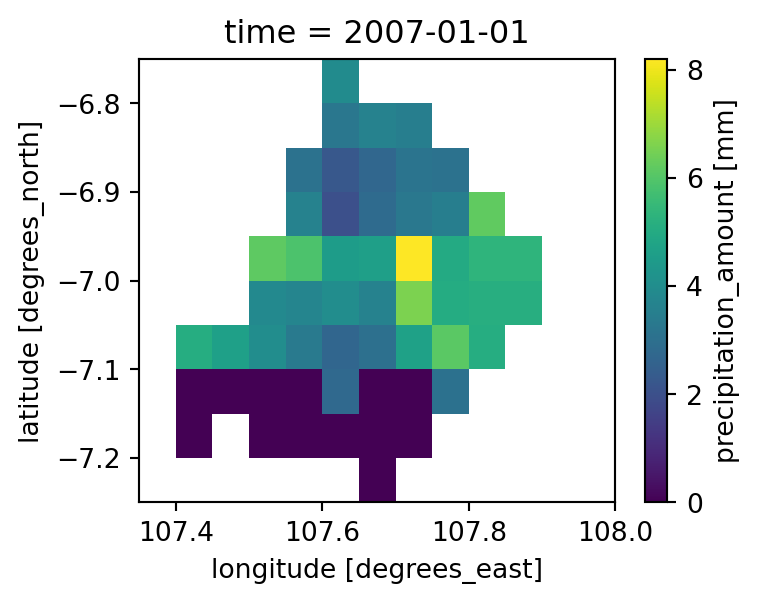

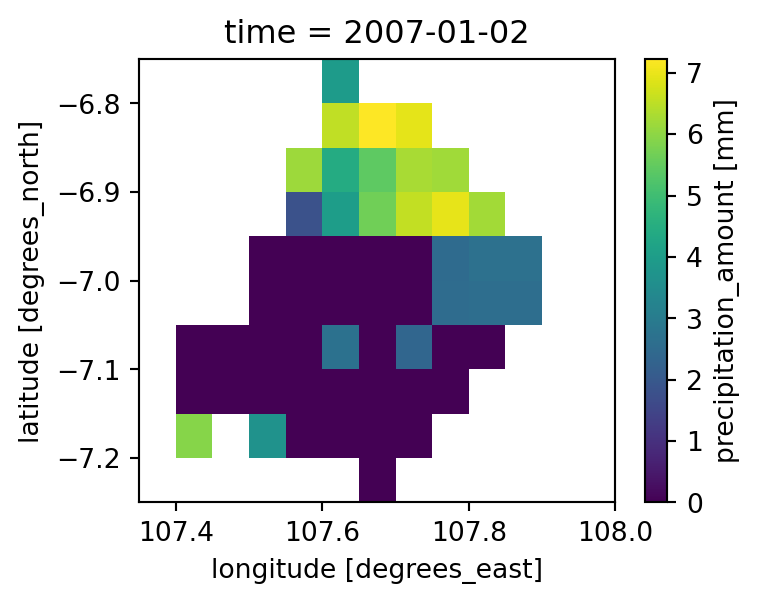

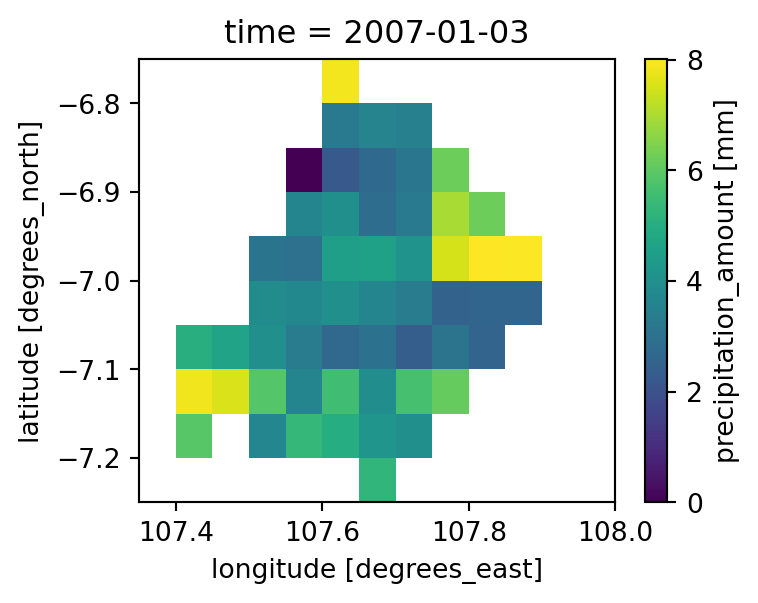

In [8]:
#| label: fig-chirps-precipitation-amount
#| fig-cap: "Precipitation from January 1st, 2007 to January 3rd, 2007"
#| fig-subcap:
#|   - "January 1st, 2007"
#|   - "January 2nd, 2007"
#|   - "January 3rd, 2007"
#| layout: [[1, 1], [1]]

def _show_plot(showtime):
    precipitation.sel(time=showtime).plot(figsize=(4,3))
    # plt.tight_layout()
    plt.show()

[
    _show_plot(showtime)
    for showtime in ["2007-01-01", "2007-01-02", "2007-01-03"]
];

Here are some observations we can make based on @fig-chirps-precipitation-amount:

*   **Spatial Variation:** We can clearly see that rainfall is not uniform across the Upper Citarum River Watershed. Different areas receive different amounts of precipitation on each day.
*   **Day-to-Day Changes:** The spatial patterns of rainfall change from day to day. For example, on January 1st @fig-chirps-precipitation-amount-1, the central part seems to receive more rainfall compared to other days. Meanwhile, on January 2nd @fig-chirps-precipitation-amount-2, the northern part of the watershed appears to have received more rainfall.
*   **Rainfall Amounts:** The color scale indicates the amount of rainfall in millimeters (mm). We can see that some areas receive up to 8 mm of rainfall on these days, while others receive very little or none.

##### Creating an Interactive Choropleth Map

For this task, we'll use the `plotly` library, which provides a high-level interface for creating interactive plots, including choropleth maps. We can leverage interactive maps to explore spatial rainfall patterns with greater flexibility. A **choropleth map** is an effective way to visualize our precipitation data, using color gradients within defined areas – in this case, grid cells – to represent rainfall amounts.

We've created an interactive choropleth map for January 1st, 2007 using the `plotly.graph_objects` library. This map (@fig-interactive-chirps-2007-01-01) displays CHIRPS precipitation across the Upper Citarum River Watershed, with each grid cell colored according to its rainfall value. The watershed boundary is also overlaid, providing context.

In [9]:
#| label: fig-interactive-chirps-2007-01-01
#| fig-cap: "Interactive Map of Precipitation on January 1st, 2007"

precip_geo_d1, precip_d1 = myfunc.generate_geojson_and_dataframe(precipitation, "2007-01-01")

# Create a Choroplethmap trace for the interactive map
precip_d1_trace = go.Choroplethmap(
    name="Precipitation",
    geojson=precip_geo_d1,
    locations=precip_d1["Location"],
    z=precip_d1["Precipitation"],
    featureidkey="properties.id",
    colorscale="Viridis",
    # colorbar=dict(title="Precipitation (mm)"),
    marker=dict(opacity=0.5, line_width=0),
    hovertemplate="<b>Location:</b> %{location}<br>"
    + "<b>Precipitation:</b> %{z:.3s} mm<br>"
    + "<extra></extra>",
    showscale=True,

)

fig = go.Figure()
fig.add_trace(citarum_watershed)  
fig.add_trace(precip_d1_trace) 
fig.update_layout(
    margin={"l": 0, "t": 0, "b": 0, "r": 0},
    map={
        "style": "open-street-map",
        "center": {"lon": np.mean(longs), "lat": np.mean(lats)},
        "zoom": 9,
    },
    height=500,
    showlegend=False,
)

fig.show()

**Interactive Features:**

*   **Hover:** Displays the location (latitude, longitude) and precipitation value of a cell on mouse hover.
*   **Zoom:** Allows closer examination of specific areas.
*   **Pan:** Enables map movement to focus on regions of interest.

This interactive map offers a powerful way to explore spatial rainfall patterns, and could be further enhanced by adding a time-selection slider or linking to time-series plots for specific locations in Dash application.